In [1]:
import pandas as pd; pd.set_option('precision',4)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np; np.set_printoptions(precision=4,suppress = True)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.gridspec as gridspec
from datetime import datetime

fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title


# StandardScale all x-variables - improves performance and robustness of fitted models
from sklearn.preprocessing import StandardScaler

# All subsets need their own scaler in order to call the inverse_transform method
scaler_train = StandardScaler()
scaler_test = StandardScaler()
scaler_all = StandardScaler()


def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.4f}%")
    else:
        print(text, f"{value:.4f}")

In [2]:
import os 
cwd = os.getcwd()
print(os.getcwd())
os.chdir('/home/math/PycharmProjects/hmm-master')

/home/math/PycharmProjects/hmm-master/notebooks


In [3]:
df = pd.read_excel('data/Adjusted Close Price Series Load.xlsx', header = 2, index_col = 'Time / Name')
df_MSCI = df[['MSCI World']]
df_MSCI.head()

,MSCI World
Time / Name,
1980-01-01,7.0217
1980-01-02,6.9258
1980-01-03,6.9075
1980-01-04,6.9630
1980-01-07,6.9889


In [4]:
df_MSCI['Returns'] = df_MSCI['MSCI World'].pct_change()
df_MSCI['Log returns'] = np.log(df_MSCI['MSCI World']) - np.log(df_MSCI['MSCI World'].shift(1))
df_MSCI.dropna(inplace=True)
df_MSCI.head(-5)

,MSCI World,Returns,Log returns
Time / Name,,,
1980-01-02,6.9258,-0.0137,-0.0138
1980-01-03,6.9075,-0.0026,-0.0027
1980-01-04,6.9630,0.0080,0.0080
1980-01-07,6.9889,0.0037,0.0037
1980-01-08,7.0757,0.0124,0.0123
...,...,...,...
2021-01-12,167.0883,0.0012,0.0012
2021-01-13,167.5403,0.0027,0.0027
2021-01-14,167.4257,-0.0007,-0.0007


### Train and Test period

In [5]:
start_train = '1980-01-01'
end_train = '2014-01-01'

start_test = '2014-01-02'
end_test = '2021-01-18'

# Get train and test as datetimes - used for plotting
start_train_dt = datetime.strptime(start_train, '%Y-%m-%d')
end_train_dt = datetime.strptime(end_train, '%Y-%m-%d')
start_test_dt = datetime.strptime(start_test, '%Y-%m-%d')
end_test_dt = datetime.strptime(end_test, '%Y-%m-%d')

df = df.loc[start_train:end_test]

In [6]:
#Get train & test sets - keep as Dataframe as oppossed to pandas series.
x_train = pd.DataFrame(df_MSCI.loc[start_train:end_train, 'Log returns'])
x_test = pd.DataFrame(df_MSCI.loc[start_test:end_test, 'Log returns'])
x_all = pd.DataFrame(df_MSCI.loc[start_train:end_test, 'Log returns'])

In [7]:
#Scale train & test sets
x_train_scaled = pd.DataFrame(scaler_train.fit_transform(x_train),
             columns = ["Log returns"],
             index=x_train.index)
x_test_scaled = pd.DataFrame(scaler_test.fit_transform(x_test), columns =['Log returns'], index = x_test.index)

x_all_scaled = pd.DataFrame(scaler_all.fit_transform(x_all), columns = ['Log returns'], index = x_all.index)

In [8]:
#Set variable for index prices and set index 100 to first obs - only used for plotting
prices = df.loc[start_train:end_test , 'MSCI World']
prices = df.loc[:,"MSCI World"] / df.iloc[0]["MSCI World"] * 100

### Data Exploration

#### Overview of time series


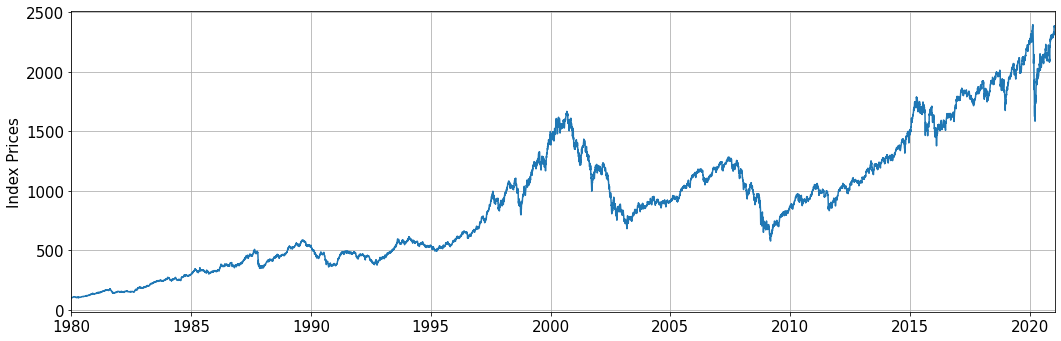

In [9]:
def plot_test_area(ax):
    #Set grey background for in-sample data
    ax.axvspan(start_train_dt, end_train_dt, alpha=0.5, color='white')
    ax.axvspan(start_test_dt, end_test_dt, alpha=0.5, color='grey', label = "Out of sample")

    
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(prices)
plt.ylabel('Index Prices')
plt.xlim(start_train_dt, end_test_dt)
plt.grid()
plt.tight_layout()
plt.savefig("MSCI World")

In [10]:
# Summary statistics of train and test data
printf("Train/Total OBS ratio = ", len(x_train)/len(x_all) , pct=True)

for data,sample in zip([x_train, x_test],["In-sample", "Out of sample"]):
    print("-"*40)
    print(sample,"\n")
    display(pd.DataFrame(data.describe(include='all')).T.round(4))

    printf("Skewness = ", stats.skew(data.round(4))[0])
    printf("Excess Kurtosis = ", stats.kurtosis(data)[0])

Train/Total OBS ratio =  82.8369%
----------------------------------------
In-sample 



,count,mean,std,min,25%,50%,75%,max
Log returns,8871.0,0.0003,0.0099,-0.1134,-0.0046,0.0005,0.0055,0.0876


Skewness =  -0.2768
Excess Kurtosis =  8.0464
----------------------------------------
Out of sample 



,count,mean,std,min,25%,50%,75%,max
Log returns,1838.0,0.0003,0.0103,-0.1069,-0.0037,0.0007,0.0052,0.083


Skewness =  -1.2470
Excess Kurtosis =  18.6644


In [11]:
np.max(df_MSCI['Log returns'].loc[start_train_dt:end_train_dt]) #Test function for the statistics above, out of sample

0.08760270641696177

#### Overview of log returns

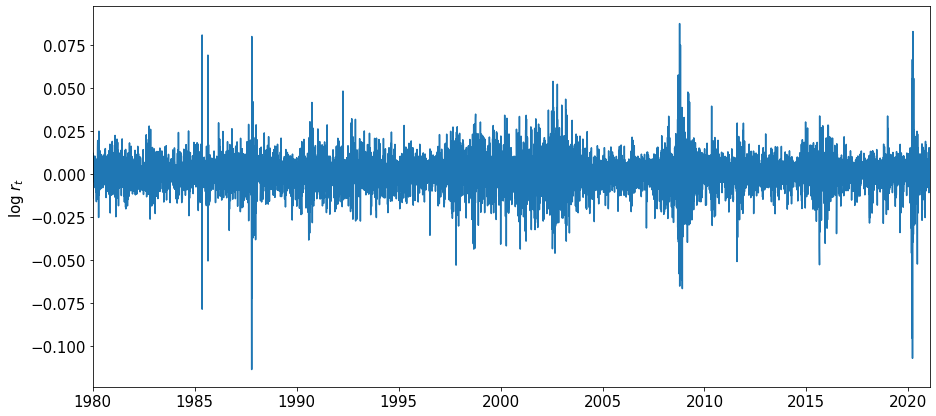

In [12]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(x_all)
ax1.set_ylabel('log $r_t$')
plt.xlim(start_train_dt, end_test_dt)
plt.savefig('Log returns')

### ACF and ACF^2 - Absence of Linear Autocorrelation and Volatility clustering


In [23]:
#### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(x_train,nlags = n_lags)[1:]  #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_squared = sm.tsa.acf(x_train**2, nlags=n_lags)[1:]

In [58]:
np.mean(acf)

0.0024749739479668566

In [59]:
#### Confidence interval for ACF
acf_conf = [1.96  / np.sqrt(len(x_train)), -1.96 / np.sqrt(len(x_train))]

#### Confidence interval for ACF^2
acf_squared_conf = [1.96 / np.sqrt(len(x_train**2)), - 1.96 / np.sqrt(len(x_train**2))]

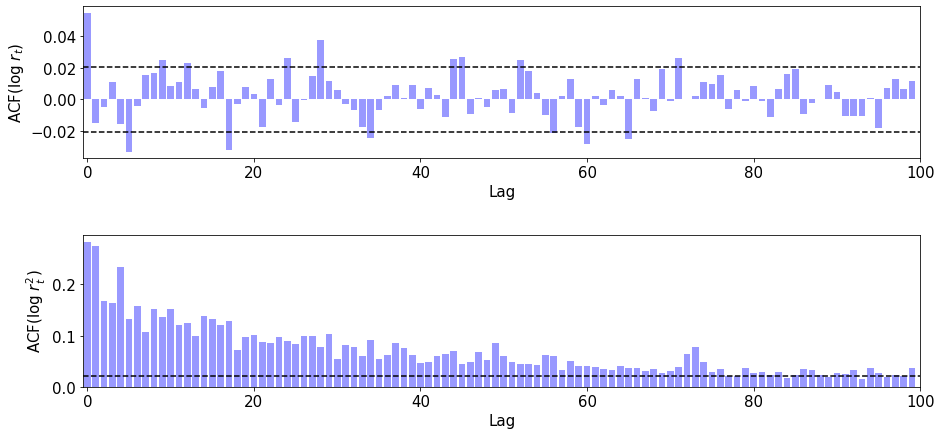

In [60]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF(log $r^2_t$)"]
variables = [acf, acf_squared]
confidence = [acf_conf, acf_squared_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="b", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig("ACF")
